# Multi-Agent Financial Analysis System

**Group Name:** AAI-520 Group 14

**Team Members:** Jagadeesh Kumar Sellappan, Saurav Kumar Subudhi. 

**GitHub Repository:** https://github.com/jagadeesh-usd/AI-Financial-Analysis-Agent.git  

---

## Project Overview

This notebook implements a sophisticated multi-agent financial analysis system using LangChain and LangGraph. The system is designed to automate the process of investment research by coordinating multiple specialized AI agents to perform complex tasks end-to-end.

The core architecture follows a **Planner-Executor** model, augmented with a **Critique-Refinement** loop to ensure the quality and objectivity of the final analysis. This agentic approach moves beyond simple, scripted pipelines by enabling agents to reason, plan, delegate, and self-correct, mimicking the workflow of a human financial research team.

In [264]:
# Install necessary packages
# !pip install -q python-dotenv langchain-openai yfinance fredapi edgartools pytrends langgraph

In [265]:
# Import libraries and load environment variables
import json
import os
import pprint
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import requests

from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from dotenv import load_dotenv
from edgar import Company, set_identity
from fredapi import Fred
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain.tools import Tool
from langchain_openai import ChatOpenAI
from pytrends.request import TrendReq
import yfinance as yf
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator



In [266]:
# Load API keys from your .env file
load_dotenv()

# Check for the OpenAI API key
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please create a .env file.")


In [267]:
def clean_filing_content(text):
    """
    Clean the extracted filing content by removing XBRL/inline tags and normalizing whitespace.
    """
    # Remove all XBRL/inline tags (e.g., xbrli:shares, iso4217:USD, us-gaap:*, etc.)
    text = re.sub(r'\b(xbrli|us-gaap|dei|srt|aapl|intc):[^\s>]+', '', text)

    # Remove standalone tags like "P1Y", "c-1", "f-46", etc.
    text = re.sub(r'\b([A-Za-z]+-[0-9]+|[A-Za-z]+[0-9]+|[A-Z]{2,}[A-Za-z]*\d*)\b', '', text)

    # Remove dates in the format "YYYY-MM-DD" if they are standalone
    text = re.sub(r'(?<!\d)\d{4}-\d{2}-\d{2}(?!\d)', '', text)

    # Remove numbers like "0000050863" if they are standalone
    text = re.sub(r'(?<!\d)\d{8,}(?!\d)', '', text)

    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text


## Agent Design and Workflows

This system is built on a foundation of several key agentic workflow patterns that enable complex, autonomous behavior. The primary architectural choice is the **Planner-Executor** pattern, which separates the "thinking" from the "doing" to improve reliability and efficiency.


### 1. The Planner-Executor Workflow

The workflow begins with a clear separation of duties:

1.  **Planning Phase (`planner_node`):** A specialized **Planner Agent** is invoked first. Its sole responsibility is to create a strategic research plan. It performs a single, low-cost action—calling the `get_company_info` tool—to determine the company's market cap and sector. Based on this profile, it dynamically selects the appropriate set of tools for a deeper analysis and outputs its reasoning along with a structured plan (a JSON array of tool names).

2.  **Execution Phase (`executor_node`):** The plan is then passed to an **Executor Agent**. This agent's job is to mindlessly and efficiently execute the provided plan. Its internal protocol mandates that it **always** calls `read_notes_from_memory` first to gather historical context. Following that, it sequentially invokes each tool from the planner's list, gathering all the necessary data points before synthesizing an `initial_analysis`.

### 2. Specialist Agent Delegation (Prompt Chaining)

Within the Execution phase, the `executor_agent` demonstrates another key pattern: delegation to a specialist. When it needs to analyze news, it doesn't process the raw headlines itself. Instead, it calls the **`Financial_News_Analyst` tool**, which is a self-contained agent. This specialist agent performs an entire internal workflow (Ingest → Classify → Summarize) in a single call, returning a concise, high-level summary. This is an example of **Prompt Chaining**.

In [268]:
try:
    fred_api_key = os.environ.get("FRED_API_KEY")
    fred = Fred(api_key=fred_api_key)
except Exception:
    warnings.warn(
        "FRED API key not found in Streamlit secrets. The economic data tool will be disabled."
    )
    fred = None

# --- Memory Component ---
MEMORY_FILE = "memory.json"


#### Agentic Tools Definition

In [269]:
# Define memory tools for learning across runs
@tool
def read_notes_from_memory(ticker: str) -> list[str]:
    """
    Reads past analysis notes for a given stock ticker to provide context for a new analysis.
    Use this tool FIRST before any other tool to get historical context.
    """
    if not os.path.exists(MEMORY_FILE):
        return ["No past notes found for this ticker."]
    
    with open(MEMORY_FILE, 'r') as f:
        try:
            data = json.load(f)
            return data.get(ticker, ["No past notes found for this ticker."])
        except json.JSONDecodeError:
            return ["Memory file is empty or corrupted."]


@tool
def save_note_to_memory(ticker: str, note: str) -> str:
    """
    Saves a single, concise key takeaway from the latest analysis to memory for future reference.
    Use this tool LAST after the analysis is complete. The note should be a single sentence.
    """
    if not isinstance(note, str) or not note.strip():
        return "Error: Note must be a non-empty string."
        
    if os.path.exists(MEMORY_FILE) and os.path.getsize(MEMORY_FILE) > 0:
        with open(MEMORY_FILE, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    if ticker not in data:
        data[ticker] = []
    
    note_with_date = f"[**{datetime.now().strftime('%Y-%m-%d')}**] - {note.strip()}"
    data[ticker].append(note_with_date)
    data[ticker] = data[ticker][-3:]

    with open(MEMORY_FILE, 'w') as f:
        json.dump(data, f, indent=4)
        
    return f"Successfully saved note for {ticker}."


In [270]:
@tool
def get_company_info(ticker: str) -> dict:
    """Retrieves general information and key metrics for a given stock ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    market_cap = info.get('marketCap')
    return {
        "longName": info.get('longName', 'N/A'),
        "marketCap": f"${market_cap:,}" if isinstance(market_cap, (int, float)) else 'N/A',
        "sector": info.get('sector', 'N/A'),
    }

In [271]:
@tool
def get_stock_news(ticker: str) -> list[str]:
    """Fetches the latest news headlines for a given stock ticker."""
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        if not news:
            return ["No recent news found."]
        return [
            article['content']['title'] 
            for article in news[:10]
            if 'content' in article and 'title' in article.get('content', {})
        ]
    except Exception as e:
        return [f"An error occurred: {e}"]

In [272]:
@tool
def search_specific_news(ticker: str, keywords: list[str]) -> list[str]:
    """
    Searches for news articles about a company from the last 30 days that contain 
    specific keywords. Use this to find targeted information like 'partnerships', 
    'acquisitions', 'speculation', 'product launch', or 'regulatory approval'. 
    The `keywords` argument should be a list of search terms.
    """
    try:
        api_key = os.environ.get("NEWS_API_KEY")
    except Exception:
        return ["Error: NewsAPI key not found"]

    # Calculate date 30 days ago
    date_from = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

    # Format keywords for the API query
    query_keywords = " OR ".join(keywords)
    query = f'"{ticker}" AND ({query_keywords})'

    url = (f'https://newsapi.org/v2/everything?'
           f'q={query}&'
           f'from={date_from}&'
           f'sortBy=relevancy&'
           f'apiKey={api_key}')

    try:
        response = requests.get(url)
        response.raise_for_status()
        articles = response.json().get('articles', [])

        if not articles:
            return [f"No specific news found for keywords '{', '.join(keywords)}' in the last 30 days."]

        # Return a list of the top 5 most relevant headlines
        return [article['title'] for article in articles[:5]]

    except Exception as e:
        return [f"An error occurred while fetching specific news: {e}"]


In [273]:
@tool
def get_price_summary(ticker: str) -> dict:
    """
    Retrieves a comprehensive price summary and key technical indicators for a stock.
    Provides the latest price, 52-week range, 50-day and 200-day moving averages, 
    and the 14-day Relative Strength Index (RSI) to understand the stock's trend and momentum.
    """
    try:
        stock = yf.Ticker(ticker)
        # Fetch 1 year of data to calculate all indicators
        hist = stock.history(period="1y")
        if hist.empty:
            return {"error": "Could not retrieve price history."}

        # --- Key Price Points ---
        latest_close = hist['Close'].iloc[-1]
        fifty_two_week_high = hist['High'].max()
        fifty_two_week_low = hist['Low'].min()

        # --- Trend Indicators (Moving Averages) ---
        # Calculate 50-day and 200-day moving averages
        ma_50 = hist['Close'].rolling(window=50).mean().iloc[-1]
        ma_200 = hist['Close'].rolling(window=200).mean().iloc[-1]

        # Determine trend based on MAs
        if latest_close > ma_50 and ma_50 > ma_200:
            trend = "Strong Uptrend"
        elif latest_close > ma_50 and latest_close > ma_200:
            trend = "Uptrend"
        elif latest_close < ma_50 and ma_50 < ma_200:
            trend = "Strong Downtrend"
        elif latest_close < ma_50 and latest_close < ma_200:
            trend = "Downtrend"
        else:
            trend = "Sideways/Consolidating"

        # --- Momentum Indicator (RSI) ---
        delta = hist['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        latest_rsi = rsi.iloc[-1]

        # Determine overbought/oversold condition
        if latest_rsi > 70:
            rsi_condition = "Overbought"
        elif latest_rsi < 30:
            rsi_condition = "Oversold"
        else:
            rsi_condition = "Neutral"

        return {
            "latest_price": f"${latest_close:.2f}",
            "52_week_high": f"${fifty_two_week_high:.2f}",
            "52_week_low": f"${fifty_two_week_low:.2f}",
            "trend_analysis": {
                "50_day_ma": f"${ma_50:.2f}",
                "200_day_ma": f"${ma_200:.2f}",
                "trend_conclusion": trend
            },
            "momentum_analysis": {
                "rsi_14_day": f"{latest_rsi:.2f}",
                "condition": rsi_condition
            }
        }
    except Exception as e:
        return {"error": f"Failed to calculate price summary: {e}"}


In [274]:
@tool
def get_financial_ratios(ticker: str) -> dict:
    """
    Calculates and returns key financial ratios for a given stock ticker.
    This provides insights into the company's valuation, profitability, and financial health.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        ratios = {
            "trailing_pe": info.get("trailingPE", "N/A"),
            "forward_pe": info.get("forwardPE", "N/A"),
            "price_to_book": info.get("priceToBook", "N/A"),
            "price_to_sales": info.get("priceToSalesTrailing12Months", "N/A"),
            "debt_to_equity": info.get("debtToEquity", "N/A"),
            "return_on_equity": info.get("returnOnEquity", "N/A"),
            "profit_margins": info.get("profitMargins", "N/A"),
        }

        return ratios
    except Exception as e:
        return {"error": f"Could not retrieve financial ratios: {e}"}


In [275]:
@tool
def get_analyst_ratings(ticker: str) -> dict:
    """
    Fetches the latest analyst ratings and price targets for a stock.
    This helps understand the consensus view from market professionals.
    """
    try:
        stock = yf.Ticker(ticker)
        # Use recommendations_summary which is often more consistent
        recommendations = stock.recommendations_summary

        if recommendations.empty:
            return {"message": "No analyst ratings found for this period."}

        # The data is often in a single row, so we access it directly.
        latest_summary = recommendations.iloc[0]

        # Use .get() to safely access keys that might be missing
        strong_buy = latest_summary.get('strongBuy', 0)
        buy = latest_summary.get('buy', 0)
        hold = latest_summary.get('hold', 0)
        sell = latest_summary.get('sell', 0)
        strong_sell = latest_summary.get('strongSell', 0)

        summary = {
            "period": latest_summary.get('period', 'N/A'),
            "buy_ratings": int(strong_buy + buy),
            "hold_ratings": int(hold),
            "sell_ratings": int(sell + strong_sell),
        }

        # Get the latest specific recommendations if available
        rec_details = stock.recommendations
        if not rec_details.empty:
            latest_ratings = rec_details.tail(5)
            firm_col = 'Firm' if 'Firm' in latest_ratings.columns else 'firm'
            grade_col = 'To Grade' if 'To Grade' in latest_ratings.columns else 'toGrade'
            if firm_col in latest_ratings.columns and grade_col in latest_ratings.columns:
                summary["latest_recommendations"] = latest_ratings[[firm_col, grade_col]].to_dict('records')
            else:
                summary["latest_recommendations"] = []
        else:
            summary["latest_recommendations"] = []

        return summary
    except Exception as e:
        return {"error": f"Could not retrieve analyst ratings: {e}"}

In [ ]:
import yfinance as yf
from pytrends.request import TrendReq

@tool
def get_google_trends(ticker: str, timeframe: str = 'today 3-m') -> dict:
    """
    Fetches Google Trends data for a company by first looking up its name from the ticker.
    This is useful for gauging public interest in a company or its products.
    """
    try:
        # 1. Look up the company's name from the ticker.
        stock = yf.Ticker(ticker)
        # Use the longName, but fall back to the ticker if it's not available.
        keyword = stock.info.get('longName', ticker)

        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='', gprop='')
        interest_over_time_df = pytrends.interest_over_time()

        if interest_over_time_df.empty or keyword not in interest_over_time_df.columns:
            return {"message": f"No Google Trends data found for '{keyword}'."}

        avg_interest = interest_over_time_df[keyword].mean()
        peak_interest_date = interest_over_time_df[keyword].idxmax().strftime('%Y-%m-%d')

        return {
            "keyword_searched": keyword,
            "average_interest_score": round(avg_interest, 2),
            "peak_interest_date": peak_interest_date,
            "comment": f"The average interest score for '{keyword}' is {round(avg_interest, 2)} out of 100 over the last 3 months.",
        }
    except Exception as e:
        return {"error": f"Could not retrieve Google Trends data: {e}"}


In [277]:
@tool
def get_economic_data(series_id: str = 'GDP') -> dict:
    """
    Fetches the latest data for a given economic series from FRED.
    Use this to understand the broader economic context. For example,
    use series_id 'GDP' for GDP data.
    """
    if fred is None:
        return {"error": "FRED API key not configured. Cannot fetch economic data."}

    try:
        data = fred.get_series(series_id)
        latest_value = data.iloc[-1]
        latest_date = data.index[-1].strftime('%Y-%m-%d')
        return {
            "series": series_id,
            "latest_value": f"{latest_value:,.2f}",
            "latest_date": latest_date
        }
    except Exception as e:
        return {"error": f"Failed to fetch data for series {series_id}: {e}"}


In [278]:
@tool
def get_latest_filings(ticker: str, top_n: int = 1) -> list[dict]:
    """
    Fetch latest 10-K / 10-Q filings for the ticker.
    Returns a list of dicts with metadata and cleaned content.
    """
    try:
        # Identify to SEC
        set_identity("jagadeesch1981@gmail.com")
        company = Company(ticker.upper())
        filings = company.get_filings().filter(form=["10-K", "10-Q"])
        filings_df = filings.to_pandas()
        results = []
        for _, filing_row in filings_df.head(top_n).iterrows():
            filing_dict = filing_row.to_dict()
            # Prefer the filing's cik; fallback to company.cik if not present
            cik_raw = (
                filing_row.get("cik")
                or getattr(company, "cik", None)
                or filing_row.get("company_info", {}).get("cik")
            )
            if not cik_raw:
                results.append({
                    "error": "No CIK available for this filing.",
                    "filing_meta": filing_dict
                })
                continue
            cik = str(cik_raw).replace("-", "").zfill(10)  # zero-pad to 10 digits
            accession = str(
                filing_row.get("accession_number")
                or filing_row.get("accessionNo")
                or ""
            ).replace("-", "")
            primary_document = (
                filing_row.get("primaryDocument")
                or filing_row.get("primary_doc")
                or ""
            )
            # Construct canonical document URL
            document_url = None
            if accession and primary_document:
                document_url = (
                    f"https://www.sec.gov/Archives/edgar/data/{cik}/"
                    f"{accession}/{primary_document}"
                )
            # Fallback URLs
            fallback_urls = []
            if filing_row.get("filing_href"):
                fallback_urls.append(filing_row.get("filing_href"))
            if filing_row.get("linkToFilingDetails"):
                fallback_urls.append(filing_row.get("linkToFilingDetails"))
            if filing_row.get("filing_url"):
                fallback_urls.append(filing_row.get("filing_url"))
            # Try primary constructed URL first, then fallbacks
            tried_urls = []
            headers = {"User-Agent": "jagadeesch1981@gmail.com"}
            response_text = None
            for url in ([document_url] if document_url else []) + fallback_urls:
                if not url:
                    continue
                tried_urls.append(url)
                try:
                    resp = requests.get(url, headers=headers, timeout=15)
                    resp.raise_for_status()
                    response_text = resp.text
                    used_url = url
                    break
                except requests.exceptions.HTTPError:
                    continue
                except requests.exceptions.RequestException as e:
                    results.append({
                        "error": f"Network error fetching filing: {e}",
                        "filing_meta": filing_dict,
                        "tried_urls": tried_urls,
                    })
                    response_text = None
                    break
            if not response_text:
                results.append({
                    "error": "Could not fetch filing document (404 or unavailable).",
                    "filing_meta": filing_dict,
                    "tried_urls": tried_urls,
                })
                continue
            # Clean the text
            soup = BeautifulSoup(response_text, "html.parser")
            # Remove all XBRL and XML tags
            for tag in soup.find_all(True, {"name": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xlink": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xbrli": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"us-gaap": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"dei": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"srt": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"aapl": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"intc": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ixt": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ixt-sec": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xbrldi": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xsi": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"iso4217": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ecd": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xml": True}):
                tag.decompose()
            # Remove all <head> tags
            if soup.head:
                soup.head.decompose()
            # Get the cleaned text
            cleaned_text = soup.get_text(separator=" ", strip=True)
            # Further clean the text using regex
            cleaned_text = clean_filing_content(cleaned_text)
            results.append({
                "form_type": filing_dict.get("form"),
                "filed_at": str(
                    filing_dict.get("filing_date")
                    or filing_dict.get("filingDate")
                ),
                "accession_number": accession,
                "url": used_url,
                "content": cleaned_text,
                "meta": filing_dict,
            })
        if not results:
            return [{"error": f"No recent 10-K or 10-Q filings found for {ticker}."}]
        return results
    except Exception as e:
        return [{"error": f"Failed to fetch SEC filings for ticker {ticker}: {e}"}]


#### Agent Creation Factory

In [ ]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    """
    Create an agent for processing inputs using the specified language model and tools.

    Args:
        llm (ChatOpenAI): The language model to be used by the agent.
        tools (list): A list of tools that the agent can utilize.
        system_prompt (str): A prompt that guides the agent's responses.

    Returns:
        AgentExecutor: An executor instance that manages the agent's operations 
                       and interactions with the provided tools.
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    
    agent = create_openai_functions_agent(llm, tools, prompt)
    
    return AgentExecutor(agent=agent, tools=tools, verbose=False, return_intermediate_steps=True)


## Agent Functions and Capabilities

The agents in this system are designed with specific functions that align with the core requirements of an agentic AI.

### 1. Planning (`planner_agent`)
The system explicitly demonstrates planning capabilities. The **Planner Agent**'s primary function is to create a dynamic, context-aware research plan. It reasons about the company's profile (Penny Stock, Mid-Cap, etc.) and outputs a precise list of tools for the next agent to execute.

### 2. Dynamic Tool Use (`executor_agent`)
The **Executor Agent** showcases dynamic tool use. It is not hardcoded to run a fixed sequence of tools. Instead, it receives a plan as input and dynamically invokes the tools specified in that plan, allowing its behavior to adapt to the specific research task at hand.

### 3. Self-Reflection (`critic_agent`)
Self-reflection is implemented through the **Critic Agent**. After the `executor_agent` generates its initial analysis, the `critic_agent` is invoked to assess the quality of that output. It evaluates the analysis against predefined criteria: **Balance**, **Clarity**, and **Objectivity**, providing structured feedback for improvement.

### 4. Learning Across Runs (Memory Tools)
The system has a persistent memory implemented via the `read_notes_from_memory` and `save_note_to_memory` tools.
- At the **start** of every run, the executor agent is mandated to call `read_notes_from_memory`, ensuring it has historical context.
- At the **end** of the workflow, the `save_memory_node` generates a concise takeaway from the final report and saves it to a JSON file, allowing the system to learn and improve its context for future analyses of the same stock.

#### Agent Definitions

In [280]:
def get_news_analyst_agent(llm: ChatOpenAI):
    """
    Defines a specialist agent that performs a multi-step news analysis chain.
    """
    # This agent only needs one tool: the ability to get raw news headlines.
    news_analyst_tools = [get_stock_news]

    # This detailed prompt IS the "Prompt Chain". It instructs the agent on the exact sequence of steps.
    news_analyst_prompt = (
        "You are an expert financial news analyst. Your goal is to produce a concise summary of the latest news sentiment.\n\n"
        "Follow this exact multi-step process:\n"
        "1. **Ingest:** First, use the `get_stock_news` tool to fetch the latest raw news headlines for the given stock ticker.\n"
        "2. **Classify & Analyze:** Internally, classify the sentiment of each headline (Positive, Negative, Neutral) "
        "and identify the key topics being discussed (e.g., earnings, partnerships, market trends).\n"
        "3. **Summarize:** Finally, synthesize your findings into a concise, 2-3 sentence summary that captures the overall "
        "sentiment and the most important news points.\n\n"
        "Your final output MUST be only the summary paragraph. Do not output the list of headlines or your classification details."
    )
    
    return create_agent(llm, news_analyst_tools, news_analyst_prompt)



In [281]:

def get_planner_agent(llm: ChatOpenAI):
    """
    An agent that creates a research plan based on company profile.
    It only decides WHICH tools to use; it does not execute them.
    """
    # This agent only needs one tool to do its job: get_company_info
    planner_tools = [get_company_info]

    planner_system_prompt = (
        "You are an expert financial planning agent. Your goal is to create a step-by-step research plan for a given company.\n\n"
        "1. First, use the `get_company_info` tool to determine the company's market cap and sector.\n"
        "2. Based on this information, select the appropriate tools from the following list that an executor agent should run: "
        "    --- MARKET CAP BASED PLANS ---\n\n"
        "    - **Penny Stock (<$50M):** Your scope is strictly limited. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`.\n"
        "      **Forbidden Tools:** Do not use `get_latest_filings` or `get_economic_data`.\n\n"
        "    - **Small-Cap ($50M - $2B):** These are growing companies requiring a balanced analysis. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_latest_filings`, `get_financial_ratios`.\n\n"
        "    - **Mid-Cap ($2B - $10B):** These are established companies. The analysis must focus on sustainable growth and profitability. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_financial_ratios`, `get_latest_filings`, `get_economic_data`.\n\n"
        "    - **Large-Cap (>$10B):** A comprehensive analysis is required. You must use all available tools for a complete picture.\n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_financial_ratios`, `get_latest_filings`, `get_economic_data`, "
        "`get_analyst_ratings`, and `get_google_trends` (if applicable to the sector).\n\n"
        "    --- SECTOR-BASED FOCUS ---\n\n"
        "    After selecting your tools, use the company's sector to refine your focus:\n"
        "    - **Technology/Healthcare:** Focus on innovation and competition. **Use `search_specific_news` with keywords like 'partnership', "
        "'acquisition', and 'product launch'** to find key strategic moves.\n"
        "    - **Financials/Industrials:** Focus on balance sheet health, debt, and economic indicators like interest rates.\n"
        "    - **Consumer Cyclical/Defensive:** Focus on consumer sentiment and supply chain news.\n"
        "    - **Utilities/Energy/Real Estate:** Focus on debt, dividends, and interest rate sensitivity.\n\n"
        "Your final output MUST be a single, valid JSON object with two keys:\n"
        "1. `reasoning`: A text containing your reason to choose all these tools and what to achieve in a couple of lines.\n"
        "2. `plan`: A JSON array of strings, where each string is the exact name of a tool to be executed.\n\n"
    )
    
    return create_agent(llm, planner_tools, planner_system_prompt)




In [282]:
def get_executor_agent(llm: ChatOpenAI):
    """
    An agent that executes a given research plan.
    It takes a plan and calls the tools in that plan.
    """
    # The specialist news agent needs to be created here for the executor's tool list
    news_analyst_agent = get_news_analyst_agent(llm)

    def run_news_agent(ticker: str):
        return news_analyst_agent.invoke({"input": ticker})

    news_analysis_tool = Tool(
        name="Financial_News_Analyst",
        func=run_news_agent,
        description="Provides a comprehensive summary of the latest news sentiment for a given stock ticker."
    )

    # This agent needs all the tools available for execution.
    executor_tools = [
        read_notes_from_memory,
        get_price_summary,
        news_analysis_tool,
        get_economic_data,
        get_latest_filings,
        get_financial_ratios,
        get_analyst_ratings,
        get_google_trends,
        search_specific_news
    ]

    executor_system_prompt = (
        "You are an expert financial research executor. Your goal is to execute a "
        "given plan precisely.\n\n"
        "**Execution Protocol:**\n"
        "1. **MANDATORY FIRST STEP:** Always begin by using the `read_notes_from_memory` tool to gather historical context "
        "for the ticker. This is a non-negotiable first action.\n"
        "2. **Execute the Provided Plan:** After consulting memory, execute the tools listed in the user-provided plan, "
        "in the order they are given.\n\n"
        "Do not deviate from the plan or add extra tools. Your job is to execute, not to plan.\n"
        "3. **Synthesize Final Analysis:** After executing your chosen plan, combine all gathered information into a single, "
        "detailed analysis. This paragraph MUST be your final output.\n\n"
        "**Formatting Instructions:** Do not output markdown. Ensure your final output is a well-formatted, readable paragraph."
    )

    return create_agent(llm, executor_tools, executor_system_prompt)


In [283]:
def get_critic_agent(llm: ChatOpenAI):
    critic_prompt = ChatPromptTemplate.from_template(
        "You are a meticulous financial 'Critic' agent. Evaluate an analysis based on:\n"
        "1. **Balance:** Does it present both risks and opportunities?\n"
        "2. **Clarity:** Is the language clear and concise?\n"
        "3. **Objectivity:** Is the analysis data-driven?\n\n"
        "Provide short, bulleted feedback. If excellent, state 'No major changes needed'.\n\n"
        "Initial Analysis to Critique:\n{initial_analysis}"
    )
    
    return critic_prompt | llm

In [284]:
def get_refiner_agent(llm: ChatOpenAI):
    refiner_prompt = ChatPromptTemplate.from_template(
        "You are a 'Refiner' agent. Your task is to rewrite and improve an initial financial analysis based on a critique.\n\n"
        "Initial Analysis:\n{initial_analysis}\n\n"
        "Critique:\n{critique}\n\n"
        "Your Final, Rewritten Analysis:\n"
        "**Formatting instructions:** Your final output must be a well-structured report using markdown. "
        "Include a main header (e.g., '### <company name>'), use bolding for key metrics, and structure the content into clear, "
        "readable paragraphs with sub headers (##### Company Overview, Growth Drivers, Profitability and Financial Health, "
        "Cost Structure and Investments, Risks and Competitive Landscape, Market Performance and Analyst Sentiment, "
        "Recommendation, Summary)."
    )

    return refiner_prompt | llm


## Evaluation and Iteration

A key feature of this agentic system is its built-in mechanism for evaluation and iterative improvement, which is handled by the **Critique-Refinement** loop. This pattern ensures that the initial analysis does not go unchecked and is refined based on objective feedback before being presented as the final report.


The process follows a clear three-step pattern:

1.  **Generate (`executor_node`):** The **Executor Agent** first produces an `initial_analysis` based on the data it has gathered. This serves as the first draft.

2.  **Evaluate (`critic_node`):** The `initial_analysis` is then passed to the **Critic Agent**. This agent acts as an automated quality assurance step. It evaluates the draft against important criteria (e.g., Is it balanced? Does it present both risks and opportunities?) and produces a structured `critique`.

3.  **Refine (`refiner_node`):** Finally, both the `initial_analysis` and the `critique` are passed to the **Refiner Agent**. This agent's sole purpose is to rewrite and improve the initial draft by explicitly addressing the feedback from the critic. The output of this node is the polished `refined_analysis`, which becomes the final report.

This **Generate → Evaluate → Refine** cycle is a powerful form of self-correction that significantly enhances the quality, objectivity, and reliability of the system's output.

In [285]:
# Agent State
class AgentState(TypedDict):
    ticker: str
    plan: List[str] 
    reasoning: str
    research_steps: Annotated[List[dict], operator.add]
    initial_analysis: str
    critique: str
    refined_analysis: str
    memory_confirmation: str

#### Agent Nodes

In [286]:
def planner_node(state):
    """Generates the research plan and reasoning."""
    planner_agent = get_planner_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    
    # The agent now returns a JSON string
    result_json_string = planner_agent.invoke({"input": f"Create a plan for {state['ticker']}"})['output']
    
    # Parse the JSON string into a Python dictionary
    plan_data = json.loads(result_json_string)
    
    return {
        "reasoning": plan_data["reasoning"],
        "plan": plan_data["plan"]
    }


In [287]:
def executor_node(state):
    """Executes the research plan."""
    executor_agent = get_executor_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    
    # Pass both the plan and the ticker to the executor
    result = executor_agent.invoke({
        "input": f"Execute the following plan for the ticker {state['ticker']}:\n\nPLAN: {state['plan']}"
    })
    
    return {
        "research_steps": result['intermediate_steps'],
        "initial_analysis": result['output']
    }


In [288]:
def critic_node(state):
    """Critiques the initial analysis."""
    critic_agent = get_critic_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    
    critique_text = critic_agent.invoke({"initial_analysis": state["initial_analysis"]}).content
    
    # st.write(critique_text)
    return {"critique": critique_text}


In [289]:
def refiner_node(state):
    """Refines the analysis based on the critique."""
    refiner_agent = get_refiner_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    
    refined_text = refiner_agent.invoke({
        "initial_analysis": state["initial_analysis"],
        "critique": state["critique"]
    }).content
    
    # st.write(refined_text)
    return {"refined_analysis": refined_text}


In [290]:
def save_memory_node(state):
    """Generates a key insight and saves it to memory."""
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    
    # Use an LLM to generate a concise note from the refined analysis
    note_generation_prompt = ChatPromptTemplate.from_template(
        "You are a note-taking assistant. Based on the following financial analysis, "
        "generate a single, concise sentence that captures the most important takeaway. "
        "This will be saved for future reference.\n\n"
        "Analysis:\n{analysis}\n\n"
        "Your single-sentence takeaway:"
    )
    
    note_chain = note_generation_prompt | llm
    key_insight = note_chain.invoke({"analysis": state["refined_analysis"]}).content
    
    # Save the generated note to memory
    confirmation = save_note_to_memory.invoke({
        "ticker": state["ticker"],
        "note": key_insight
    })
    
    return {"memory_confirmation": confirmation}


#### Graph Definition

In [291]:
def build_agentic_workflow():
    workflow = StateGraph(AgentState)

    # Add the new nodes
    workflow.add_node("planner", planner_node)
    workflow.add_node("executor", executor_node)
    workflow.add_node("critic", critic_node)
    workflow.add_node("refiner", refiner_node)
    workflow.add_node("save_memory", save_memory_node)

    # Define the new sequence of edges
    workflow.set_entry_point("planner")
    workflow.add_edge("planner", "executor")
    workflow.add_edge("executor", "critic")
    workflow.add_edge("critic", "refiner")
    workflow.add_edge("refiner", "save_memory")
    workflow.add_edge("save_memory", END)

    return workflow.compile()


## Workflow Definition

In [292]:
from rich.panel import Panel
from rich.tree import Tree
from rich.rule import Rule
from rich.syntax import Syntax
from rich.markdown import Markdown
from rich.console import Console
import pprint
import json

console = Console()

In [293]:
def run_workflow(ticker_symbol: str):
    """Executes the workflow and prints a structured, readable report."""
    console.print(Rule(f"[bold cyan]📈 Starting Analysis for {ticker_symbol}[/bold cyan]", style="cyan"))

    stock = yf.Ticker(ticker_symbol)
    hist = stock.history(period='1y')
    plt.figure(figsize=(10, 5))
    plt.plot(hist['Close'])
    plt.title(f'{ticker_symbol} Price Trend')
    plt.show()

    agent_workflow = build_agentic_workflow()
    inputs = {"ticker": ticker_symbol}
    final_report = "Analysis could not be generated."

    for event in agent_workflow.stream(inputs):
        for node_name, value in event.items():
            if node_name == "planner":
                reasoning = value.get('reasoning', 'No reasoning provided.')
                plan = value.get('plan', [])
                plan_str = "\n".join(f"- {tool}" for tool in plan)

                content = f"[bold]Reasoning:[/bold]\n{reasoning}\n\n[bold]Plan:[/bold]\n{plan_str}"
                console.print(Panel(content, title="[bold yellow]🧠 Planner[/bold yellow]", border_style="yellow"))

            elif node_name == "executor":
                tree = Tree("🛠️ Tool Calls", guide_style="cyan")
                research_steps = value.get('research_steps', [])

                for step in research_steps:
                    action, observation = step
                    tool_name = action.tool

                    tool_branch = tree.add(f"[bold green]{tool_name}[/bold green]")

                    if isinstance(observation, dict) or isinstance(observation, list):
                        # Add a 'default=str' to handle non-serializable objects gracefully
                        obs_syntax = Syntax(json.dumps(observation, indent=2, default=str), "json",
                                            theme="monokai", line_numbers=False)
                        tool_branch.add(obs_syntax)
                    else:
                        tool_branch.add(str(observation))

                executor_panel = Panel(tree, title="[bold green]🛠️ Executor[/bold green]", border_style="green")
                console.print(executor_panel)

                initial_analysis = value.get('initial_analysis', 'No initial analysis.')
                analysis_panel = Panel(Markdown(initial_analysis), title="[bold]Initial Analysis[/bold]", border_style="dim")
                console.print(analysis_panel)

            elif node_name == "critic":
                critique = value.get('critique', 'No critique provided.')
                console.print(Panel(Markdown(critique), title="[bold magenta]🧐 Critic[/bold magenta]", border_style="magenta"))

            elif node_name == "refiner":
                final_report = value.get("refined_analysis", final_report)
                console.print(Panel("[italic]Refining the analysis based on critique...[/italic]",
                                    title="[bold blue]✍️ Refiner[/bold blue]", border_style="blue"))

            elif node_name == "save_memory":
                confirmation = value.get('memory_confirmation', 'Could not save to memory.')
                console.print(Panel(confirmation, title="[bold white]💾 Memory[/bold white]", border_style="white"))

    console.print(Rule("[bold cyan]📜 FINAL REPORT[/bold cyan]", style="cyan"))
    console.print(Panel(Markdown(final_report), border_style="bold bright_white"))
    console.print(Rule("[bold green]✅ Workflow Complete[/bold green]", style="green"))


## Execute Financial Analysis 

────────────────────────────────────────── 📈 Starting Analysis for IBIO ──────────────────────────────────────────

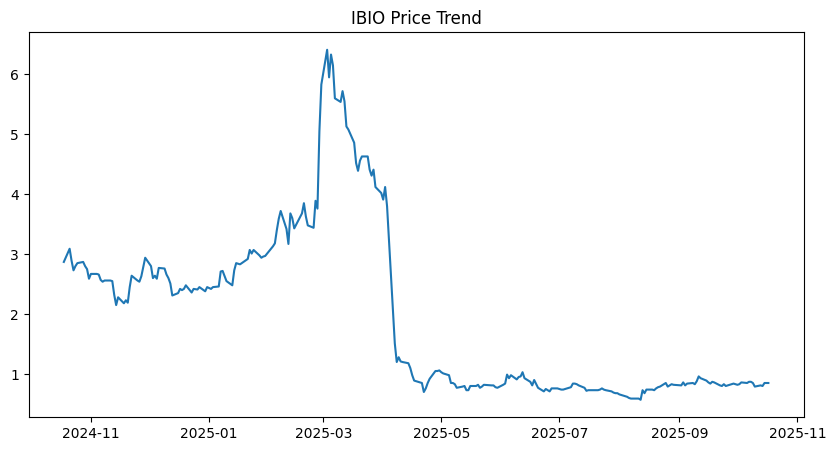

╭────────────────────────────────────────────────── 🧠 Planner ───────────────────────────────────────────────────╮
│ Reasoning:                                                                                                      │
│ iBio, Inc. is a penny stock with a market cap under $50M in the Healthcare sector. The focus should be on price │
│ summary and financial news/analyst insights to understand its innovation and competition. Using                 │
│ search_specific_news with keywords like 'partnership', 'acquisition', and 'product launch' will help identify   │
│ key strategic moves in this sector.                                                                             │
│                                                                                                                 │
│ Plan:                                                                                                           │
│ - get_price_summary                                                                                             │
│ - Financial_News_Analyst                                                                                        │
│ - search_specific_news                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🛠️ Executor ───────────────────────────────────────────────────╮
│ 🛠️ Tool Calls                                                                                                    │
│ ├── read_notes_from_memory                                                                                      │
│ │   └── [                                                                                                       │
│ │         "[**2025-10-18**] - iBio faces significant financial and transparency challenges with ongoing losses  │
│ │         "[**2025-10-18**] - iBio is a preclinical biotech firm with promising antibody pipeline potential but │
│ │         "[**2025-10-18**] - iBio faces significant financial challenges with ongoing losses and high debt but │
│ │       ]                                                                                                       │
│ ├── get_price_summary                                                                                           │
│ │   └── {                                                                                                       │
│ │         "latest_price": "$0.85",                                                                              │
│ │         "52_week_high": "$6.89",                                                                              │
│ │         "52_week_low": "$0.56",                                                                               │
│ │         "trend_analysis": {                                                                                   │
│ │           "50_day_ma": "$0.81",                                                                               │
│ │           "200_day_ma": "$1.82",                                                                              │
│ │           "trend_conclusion": "Sideways/Consolidating"                                                        │
│ │         },                                                                                                    │
│ │         "momentum_analysis": {                                                                                │
│ │           "rsi_14_day": "52.00",                                                                              │
│ │           "condition": "Neutral"                                                                              │
│ │         }                                                                                                     │
│ │       }                                                                                                       │
│ ├── Financial_News_Analyst                                                                                      │
│ │   └── {                                                                                                       │
│ │         "input": "IBIO",                                                                                      │
│ │         "output": "iBio's latest news reflects a mixed to cautiously optimistic sentiment, with a notable red │
│ │         "intermediate_steps": [                                                                               │
│ │           [                                                                                                   │
│ │             "tool='get_stock_news' tool_input={'ticker': 'IBIO'} log=\"\\nInvoking: `get_stock_news` with `{' │
│ │             [                                                                                                 │
│ │               "iBio Full Year 2025 Earnings: US$1.75 loss per share (vs US$4.03 loss in FY 2024)",            │
│ │               "Insider Buyers At iBio Likely Disappointed With 23% Slide",                                    │
│ │               "Is Ibio, Inc. (IBIO) Among Stocks Insiders Are Buying This Year?",                             │
│ │               "iBio Expands Pipeline with New Anti

╭─────────────────────────────────────────────── Initial Analysis ────────────────────────────────────────────────╮
│ Historical notes on IBIO indicate it is a preclinical biotech firm with promising antibody pipeline potential   │
│ but faces significant financial challenges, including ongoing losses and high debt, making it a high-risk       │
│ investment. The latest price summary shows IBIO trading at $0.85, near its 52-week low of $0.56 and well below  │
│ its 52-week high of $6.89, with a sideways/consolidating trend and a neutral momentum indicated by a 14-day RSI │
│ of 52. Recent news sentiment is mixed to cautiously optimistic: the company reported a notable reduction in     │
│ full-year 2025 losses compared to 2024, signaling potential financial improvement, though insider buying is     │
│ subdued amid a recent 23% stock price decline. Positively, IBIO is actively expanding its pipeline with new     │
│ antibody agreements and developments in its obesity program, reflecting ongoing innovation efforts. However, a  │
│ targeted news search for partnerships, acquisitions, product launches, or regulatory approvals yielded no       │
│ relevant recent articles, suggesting no major headline events in these areas in the last 30 days. Overall, IBIO │
│ remains a speculative, innovation-driven biotech with financial risks but some signs of pipeline progress and   │
│ improving loss metrics.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧐 Critic ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  • Balance: Well-balanced; highlights both financial risks and pipeline opportunities along with market         │
│    sentiment nuances.                                                                                           │
│  • Clarity: Generally clear and concise, though some sentences could be simplified for easier reading.          │
│  • Objectivity: Data-driven with specific financial metrics, price points, RSI values, and news sentiment;      │
│    avoids speculation.                                                                                          │
│                                                                                                                 │
│ No major changes needed.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── ✍️ Refiner ───────────────────────────────────────────────────╮
│ Refining the analysis based on critique...                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 💾 Memory ───────────────────────────────────────────────────╮
│ Successfully saved note for IBIO.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────── 📜 FINAL REPORT ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                iBio, Inc. (IBIO)                                                │
│                                                                                                                 │
│                                                Company Overview                                                 │
│                                                                                                                 │
│ iBio is a preclinical-stage biotechnology company focused on developing a pipeline of antibody-based            │
│ therapeutics. The firm is positioned in the innovation-driven biotech sector, with ongoing efforts to expand    │
│ its portfolio, particularly in areas such as obesity treatment. However, as a preclinical entity, it faces      │
│ inherent developmental and financial challenges typical of early-stage biotech firms.                           │
│                                                                                                                 │
│                                                 Growth Drivers                                                  │
│                                                                                                                 │
│ The company is actively advancing its antibody pipeline, highlighted by recent agreements to develop new        │
│ antibody candidates. Its obesity program is a notable area of focus, reflecting strategic diversification       │
│ within its therapeutic development efforts. These initiatives demonstrate iBio’s commitment to innovation and   │
│ potential future value creation.                                                                                │
│                                                                                                                 │
│                                       Profitability and Financial Health                                        │
│                                                                                                                 │
│ iBio continues to operate at a loss, with significant financial challenges including a high debt load.          │
│ Encouragingly, the company reported a notable reduction in projected full-year losses for 2025 compared to      │
│ 2024, signaling potential improvement in its financial trajectory. Despite this, ongoing losses and debt levels │
│ maintain a high-risk profile for investors.                                                                     │
│                                                                                                                 │
│                                         Cost Structure and Investments                                          │
│                                                                                                                 │
│ The company’s expenditures remain focused on research and development, particularly in expanding its antibody   │
│ pipeline and obesity program. While these investments are critical for long-term growth, they contribute to the │
│ current negative cash flow and underline the need for effective capital management.                             │
│                                                                                                                 │
│                                         Risks and Competitive Landscape                                         │
│                                                                                                                 │
│ As a preclinical biotech, iBio faces typical sector risks including clinical and regulatory uncertainties,      │
│ capital intensity, and competitive pressures from larger, more established firms. The absence of recent major   │
│ partnerships, acquisitions, product launches, or regul

────────────────────────────────────────────── ✅ Workflow Complete ───────────────────────────────────────────────

In [230]:

ticker_to_analyze = "IBIO" 
run_workflow(ticker_to_analyze)

────────────────────────────────────────── 📈 Starting Analysis for JBLU ──────────────────────────────────────────

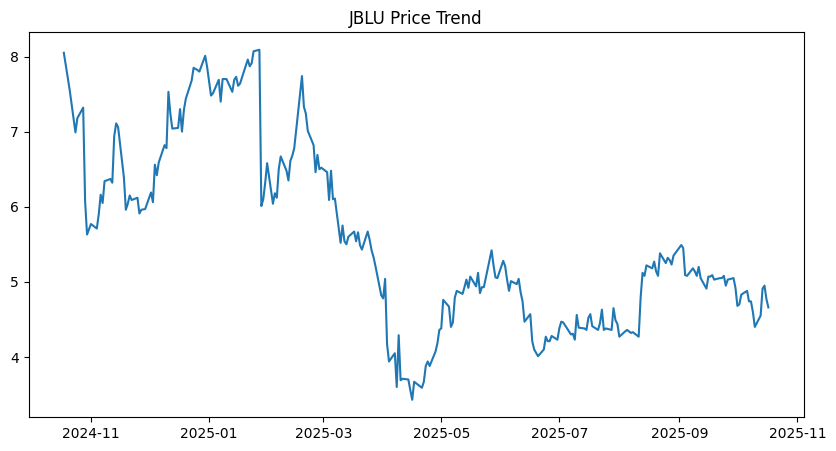

╭────────────────────────────────────────────────── 🧠 Planner ───────────────────────────────────────────────────╮
│ Reasoning:                                                                                                      │
│ JetBlue Airways Corporation is a Small-Cap company in the Industrials sector. The analysis requires a balanced  │
│ approach including price summary, financial news, latest filings, and financial ratios to understand its growth │
│ and financial health. Given the Industrials sector, focus will be on balance sheet health, debt, and economic   │
│ indicators like interest rates.                                                                                 │
│                                                                                                                 │
│ Plan:                                                                                                           │
│ - get_price_summary                                                                                             │
│ - Financial_News_Analyst                                                                                        │
│ - get_latest_filings                                                                                            │
│ - get_financial_ratios                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🛠️ Executor ───────────────────────────────────────────────────╮
│ 🛠️ Tool Calls                                                                                                    │
│ ├── read_notes_from_memory                                                                                      │
│ │   └── [                                                                                                       │
│ │         "[**2025-10-14**] - JetBlue Airways faces significant financial and operational challenges marked by  │
│ │         "[**2025-10-16**] - JetBlue Airways faces significant operational and financial challenges with high  │
│ │         "[**2025-10-18**] - JetBlue Airways faces significant financial and operational challenges with high  │
│ │       ]                                                                                                       │
│ ├── get_price_summary                                                                                           │
│ │   └── {                                                                                                       │
│ │         "latest_price": "$4.66",                                                                              │
│ │         "52_week_high": "$8.31",                                                                              │
│ │         "52_week_low": "$3.34",                                                                               │
│ │         "trend_analysis": {                                                                                   │
│ │           "50_day_ma": "$5.00",                                                                               │
│ │           "200_day_ma": "$5.24",                                                                              │
│ │           "trend_conclusion": "Strong Downtrend"                                                              │
│ │         },                                                                                                    │
│ │         "momentum_analysis": {                                                                                │
│ │           "rsi_14_day": "39.68",                                                                              │
│ │           "condition": "Neutral"                                                                              │
│ │         }                                                                                                     │
│ │       }                                                                                                       │
│ ├── Financial_News_Analyst                                                                                      │
│ │   └── {                                                                                                       │
│ │         "input": "JBLU",                                                                                      │
│ │         "output": "JetBlue (JBLU) is currently facing significant challenges, reflected in a sharp 41% share  │
│ │         "intermediate_steps": [                                                                               │
│ │           [                                                                                                   │
│ │             "tool='get_stock_news' tool_input={'ticker': 'JBLU'} log=\"\\nInvoking: `get_stock_news` with `{' │
│ │             [                                                                                                 │
│ │               "United is focused on winning brand loyal customers",                                           │
│ │               "JetBlue Shares Slide 41% in 2025 Amid Ongoing Industry Turbulence\u2014What Does the Valuation │
│ │               "CEO: AI and defense demand are remaking the space economy",                                    │
│ │               "Gov't shutdown could have lasting e

╭─────────────────────────────────────────────── Initial Analysis ────────────────────────────────────────────────╮
│ JetBlue Airways (JBLU) is currently experiencing significant financial and operational challenges, as reflected │
│ in past notes and recent data. The stock is in a strong downtrend with a latest price of $4.66, well below its  │
│ 52-week high of $8.31, and technical indicators such as the 50-day and 200-day moving averages confirm this     │
│ bearish trend. The 14-day RSI is neutral at 39.68, indicating no immediate momentum shift. Recent news          │
│ sentiment is cautious to negative, highlighting a 41% share decline amid industry turbulence and concerns over  │
│ a potential government shutdown impacting operations. The latest 10-Q filing for Q2 2025 reveals a net loss of  │
│ $74 million for the quarter and $282 million for the first half of the year, with operating income barely       │
│ positive at $6 million for the quarter. Revenue has declined due to softening demand and capacity reductions,   │
│ while costs such as salaries and maintenance have increased. The company is managing liquidity with $3.4        │
│ billion in cash and equivalents and has a $600 million undrawn credit line, but working capital is negative at  │
│ $512 million. JetBlue is actively transitioning its fleet, including selling its Embraer aircraft, and facing   │
│ challenges with engine groundings. Financial ratios show a negative forward P/E of -7.28, a low price-to-book   │
│ ratio of 0.70, and a very high debt-to-equity ratio of 391, indicating heavy leverage. Profit margins are       │
│ negative at -4.2%, and return on equity is also negative at -15.1%. Overall, JetBlue is navigating a difficult  │
│ environment with operational headwinds, high leverage, and ongoing losses, but it maintains strong liquidity    │
│ and is pursuing strategic initiatives like JetForward and partnerships to stabilize and grow. Investors should  │
│ be cautious given the current downtrend and financial stress, though the company’s liquidity and strategic      │
│ plans offer some potential for recovery if execution improves and market conditions stabilize.                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧐 Critic ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  • Balance:                                                                                                     │
│     • Presents both risks (downtrend, losses, high leverage, operational challenges) and opportunities (strong  │
│       liquidity, strategic initiatives, potential recovery).                                                    │
│     • Could emphasize opportunities slightly more to improve balance.                                           │
│  • Clarity:                                                                                                     │
│     • Language is generally clear and concise.                                                                  │
│     • Some sentences are dense with data; breaking them into shorter statements could enhance readability.      │
│  • Objectivity:                                                                                                 │
│     • Analysis is data-driven, citing specific financial metrics, technical indicators, and recent filings.     │
│     • Maintains an objective tone without speculative language.                                                 │
│                                                                                                                 │
│ Overall: Well-rounded and data-supported analysis; minor improvements in balance and sentence structure         │
│ recommended.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── ✍️ Refiner ───────────────────────────────────────────────────╮
│ Refining the analysis based on critique...                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 💾 Memory ───────────────────────────────────────────────────╮
│ Successfully saved note for JBLU.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────── 📜 FINAL REPORT ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                             JetBlue Airways (JBLU)                                              │
│                                                                                                                 │
│                                                Company Overview                                                 │
│                                                                                                                 │
│ JetBlue Airways is currently navigating a challenging financial and operational environment. The company        │
│ reported a net loss of $74 million in Q2 2025 and a cumulative loss of $282 million for the first half of the   │
│ year. Despite these setbacks, JetBlue maintains a strong liquidity position with $3.4 billion in cash and       │
│ equivalents and an undrawn credit line of $600 million, providing a buffer to manage near-term obligations.     │
│                                                                                                                 │
│                                                 Growth Drivers                                                  │
│                                                                                                                 │
│ JetBlue is actively pursuing strategic initiatives aimed at long-term growth and operational efficiency. These  │
│ include the JetForward program, fleet modernization efforts such as the sale of Embraer aircraft, and           │
│ partnerships designed to expand market reach. While demand has softened recently, these initiatives position    │
│ the company to capitalize on recovery opportunities as market conditions improve.                               │
│                                                                                                                 │
│                                       Profitability and Financial Health                                        │
│                                                                                                                 │
│ The company’s profitability remains under pressure, with operating income barely positive at $6 million for the │
│ quarter and negative profit margins of -4.2%. Return on equity stands at -15.1%, reflecting ongoing losses.     │
│ JetBlue’s financial leverage is notably high, with a debt-to-equity ratio of 391, signaling significant         │
│ reliance on debt financing. The forward price-to-earnings ratio is negative at -7.28, and the price-to-book     │
│ ratio is low at 0.70, indicating the market’s cautious valuation of the stock.                                  │
│                                                                                                                 │
│                                         Cost Structure and Investments                                          │
│                                                                                                                 │
│ Revenue has declined due to softening demand and capacity reductions, while operating costs have increased,     │
│ particularly in salaries and maintenance. The company is also managing operational challenges such as engine    │
│ groundings, which add to maintenance expenses. These cost pressures are impacting margins but are being         │
│ addressed alongside fleet transitions and efficiency programs.                                                  │
│                                                                                                                 │
│                                         Risks and Competitive Landscape                                         │
│                                                                                                                 │
│ JetBlue faces several risks, including industry turbul

────────────────────────────────────────────── ✅ Workflow Complete ───────────────────────────────────────────────

In [231]:
ticker_to_analyze = "JBLU" 
run_workflow(ticker_to_analyze)

─────────────────────────────────────────── 📈 Starting Analysis for IR ───────────────────────────────────────────

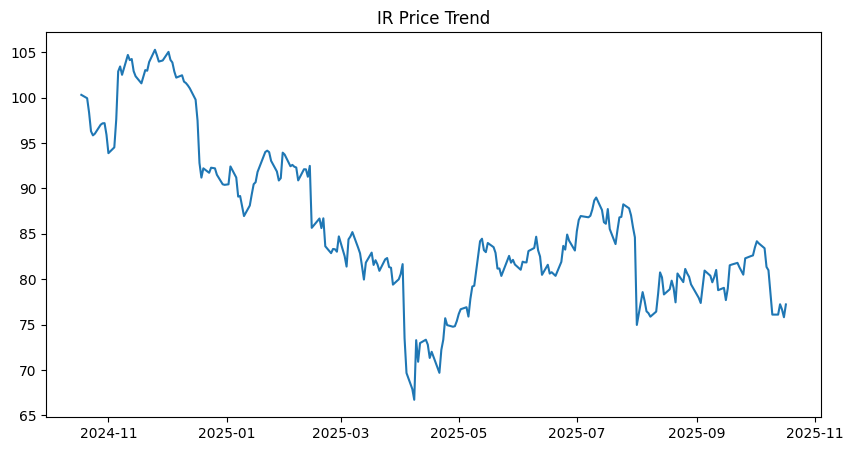

╭────────────────────────────────────────────────── 🧠 Planner ───────────────────────────────────────────────────╮
│ Reasoning:                                                                                                      │
│ Ingersoll Rand Inc. is a large-cap company with a market cap over $10B in the Industrials sector. A             │
│ comprehensive analysis is required using all available tools to get a complete picture of the company's         │
│ financial health, market performance, analyst opinions, and economic context. The focus will be on balance      │
│ sheet health, debt, and economic indicators like interest rates due to the Industrials sector.                  │
│                                                                                                                 │
│ Plan:                                                                                                           │
│ - get_price_summary                                                                                             │
│ - Financial_News_Analyst                                                                                        │
│ - get_financial_ratios                                                                                          │
│ - get_latest_filings                                                                                            │
│ - get_economic_data                                                                                             │
│ - get_analyst_ratings                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 🛠️ Executor ───────────────────────────────────────────────────╮
│ 🛠️ Tool Calls                                                                                                    │
│ ├── read_notes_from_memory                                                                                      │
│ │   └── [                                                                                                       │
│ │         "[**2025-10-14**] - Ingersoll Rand is strategically positioned for long-term growth through acquisiti │
│ │         "[**2025-10-15**] - Ingersoll Rand faces near-term challenges from asset impairments and volume softn │
│ │         "[**2025-10-15**] - Ingersoll Rand\u2019s strategic acquisitions and strong financial discipline posi │
│ │       ]                                                                                                       │
│ ├── get_price_summary                                                                                           │
│ │   └── {                                                                                                       │
│ │         "latest_price": "$77.22",                                                                             │
│ │         "52_week_high": "$105.95",                                                                            │
│ │         "52_week_low": "$65.58",                                                                              │
│ │         "trend_analysis": {                                                                                   │
│ │           "50_day_ma": "$79.77",                                                                              │
│ │           "200_day_ma": "$82.39",                                                                             │
│ │           "trend_conclusion": "Strong Downtrend"                                                              │
│ │         },                                                                                                    │
│ │         "momentum_analysis": {                                                                                │
│ │           "rsi_14_day": "30.53",                                                                              │
│ │           "condition": "Neutral"                                                                              │
│ │         }                                                                                                     │
│ │       }                                                                                                       │
│ ├── Financial_News_Analyst                                                                                      │
│ │   └── {                                                                                                       │
│ │         "input": "IR",                                                                                        │
│ │         "output": "Recent news on Ingersoll Rand (IR) presents a mixed to cautiously optimistic sentiment, wi │
│ │         "intermediate_steps": [                                                                               │
│ │           [                                                                                                   │
│ │             "tool='get_stock_news' tool_input={'ticker': 'IR'} log=\"\\nInvoking: `get_stock_news` with `{'ti │
│ │             [                                                                                                 │
│ │               "What to Expect From Ingersoll Rand's Q3 2025 Earnings Report",                                 │
│ │               "Gas and Liquid Handling Stocks Q2 Highlights: Ingersoll Rand (NYSE:IR)",                       │
│ │               "Should Investors Revisit Ingersoll Rand After the Recent 8.8% Share Price Slide?",             │
│ │               "Strength in Intelligent Devices Uni

╭─────────────────────────────────────────────── Initial Analysis ────────────────────────────────────────────────╮
│ Ingersoll Rand (IR) is currently trading at $77.22, near its 52-week low of $65.58 and well below its 52-week   │
│ high of $105.95, with technical indicators showing a strong downtrend and a neutral momentum condition (14-day  │
│ RSI of 30.53). Historical notes indicate the company is strategically positioned for long-term growth through   │
│ acquisitions and pricing power, despite near-term challenges such as volume softness, impairments, and higher   │
│ interest costs. Recent news sentiment is mixed to cautiously optimistic, focusing on upcoming Q3 2025 earnings  │
│ and potential undervaluation, with some buyout support but also cautionary views. Financial ratios reveal a     │
│ high trailing P/E of about 60 and a forward P/E of 21.8, a price-to-book ratio of 3.04, and a debt-to-equity    │
│ ratio of 49.2, indicating moderate leverage. Profit margins stand at 7.1% with a return on equity of 5.3%. The  │
│ latest 10-Q filing for Q2 2025 highlights multiple acquisitions in 2024 and 2025, ongoing restructuring         │
│ efforts, goodwill and intangible asset impairments, and a focus on managing debt and liquidity. The company     │
│ reported a net loss in Q2 2025 primarily due to impairments but showed adjusted EBITDA growth driven by         │
│ acquisitions and pricing, offset by lower organic volumes. Liquidity remains strong with over $2.6 billion in   │
│ unused credit facilities and $1.3 billion in cash. The broader economic context shows a U.S. GDP of             │
│ approximately $30.5 trillion as of April 2025, indicating a stable macroeconomic environment. Analyst ratings   │
│ are evenly split between buy and hold, with no sell ratings, reflecting a cautious but constructive market      │
│ view. Overall, Ingersoll Rand is navigating near-term operational and financial headwinds with strategic        │
│ acquisitions and disciplined financial management, positioning it for potential recovery and long-term growth   │
│ amid a stable economic backdrop.                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧐 Critic ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  • Balance:                                                                                                     │
│     • Effectively presents both risks (downtrend, volume softness, impairments, high trailing P/E, net loss)    │
│       and opportunities (acquisitions, pricing power, adjusted EBITDA growth, strong liquidity, potential       │
│       undervaluation).                                                                                          │
│     • Could improve by explicitly quantifying the potential impact of risks versus opportunities for clearer    │
│       risk/reward perspective.                                                                                  │
│  • Clarity:                                                                                                     │
│     • Generally clear and concise with well-structured information.                                             │
│     • Some sentences are dense with multiple data points; breaking them into shorter sentences could enhance    │
│       readability.                                                                                              │
│  • Objectivity:                                                                                                 │
│     • Strongly data-driven, citing specific financial metrics, technical indicators, filings, and macroeconomic │
│       context.                                                                                                  │
│     • Maintains neutral tone without speculative language, supporting conclusions with evidence.                │
│                                                                                                                 │
│ Overall: No major changes needed.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── ✍️ Refiner ───────────────────────────────────────────────────╮
│ Refining the analysis based on critique...                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 💾 Memory ───────────────────────────────────────────────────╮
│ Successfully saved note for IR.                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────── 📜 FINAL REPORT ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                               Ingersoll Rand (IR)                                               │
│                                                                                                                 │
│                                                Company Overview                                                 │
│                                                                                                                 │
│ Ingersoll Rand (IR) is currently trading at $77.22, positioned closer to its 52-week low of $65.58 than its     │
│ 52-week high of $105.95. Technical indicators reflect a strong downtrend, with a neutral momentum condition as  │
│ indicated by a 14-day RSI of 30.53. The company operates in a stable macroeconomic environment, with the U.S.   │
│ GDP at approximately $30.5 trillion as of April 2025.                                                           │
│                                                                                                                 │
│                                                 Growth Drivers                                                  │
│                                                                                                                 │
│ Ingersoll Rand’s strategic focus on growth is anchored in acquisitions and pricing power. The company completed │
│ multiple acquisitions in 2024 and 2025, which have contributed to adjusted EBITDA growth despite softness in    │
│ organic volumes. Pricing initiatives have also helped offset volume declines. These factors position IR for     │
│ potential long-term expansion, leveraging scale and market presence.                                            │
│                                                                                                                 │
│                                       Profitability and Financial Health                                        │
│                                                                                                                 │
│ The company reported a net loss in Q2 2025, primarily driven by goodwill and intangible asset impairments.      │
│ However, adjusted EBITDA showed improvement, supported by acquisitions and pricing strategies. Profit margins   │
│ stand at 7.1%, while return on equity is modest at 5.3%.                                                        │
│                                                                                                                 │
│ Financial ratios indicate a mixed picture:                                                                      │
│                                                                                                                 │
│  • Trailing P/E ratio is elevated at ~60, reflecting recent earnings challenges.                                │
│  • Forward P/E is more reasonable at 21.8, suggesting market expectations of earnings recovery.                 │
│  • Price-to-book ratio is 3.04, indicating a premium valuation relative to book value.                          │
│  • Debt-to-equity ratio of 49.2 signals moderate leverage, balanced by strong liquidity.                        │
│                                                                                                                 │
│ Liquidity remains robust, with over $2.6 billion in unused credit facilities and $1.3 billion in cash reserves, │
│ providing financial flexibility amid ongoing restructuring and debt management efforts.                         │
│                                                                                                                 │
│                                         Cost Structure and Investments                                          │
│                                                       

────────────────────────────────────────────── ✅ Workflow Complete ───────────────────────────────────────────────

In [228]:

ticker_to_analyze = "IR" 
run_workflow(ticker_to_analyze)

────────────────────────────────────────── 📈 Starting Analysis for INTC ──────────────────────────────────────────

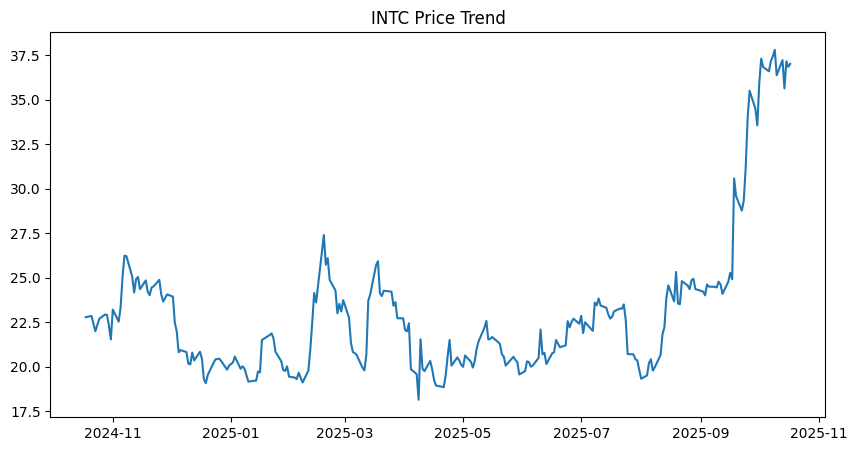

╭────────────────────────────────────────────────── 🧠 Planner ───────────────────────────────────────────────────╮
│ Reasoning:                                                                                                      │
│ Intel Corporation is a large-cap company in the Technology sector with a market cap of approximately $176       │
│ billion. A comprehensive analysis is required using all available tools to get a complete picture of its        │
│ financial health, market position, and trends. Additionally, since it is in the Technology sector, we will      │
│ focus on innovation and competition by searching for news related to partnerships, acquisitions, and product    │
│ launches.                                                                                                       │
│                                                                                                                 │
│ Plan:                                                                                                           │
│ - get_price_summary                                                                                             │
│ - Financial_News_Analyst                                                                                        │
│ - get_financial_ratios                                                                                          │
│ - get_latest_filings                                                                                            │
│ - get_economic_data                                                                                             │
│ - get_analyst_ratings                                                                                           │
│ - get_google_trends                                                                                             │
│ - search_specific_news                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Could not retrieve Google Trends data: The request failed: Google returned a response with code 429


╭────────────────────────────────────────────────── 🛠️ Executor ───────────────────────────────────────────────────╮
│ 🛠️ Tool Calls                                                                                                    │
│ ├── read_notes_from_memory                                                                                      │
│ │   └── [                                                                                                       │
│ │         "[**2025-10-19**] - Intel shows strong AI-driven growth potential and technical momentum but faces si │
│ │         "[**2025-10-19**] - Intel shows strong technical momentum and promising AI-driven growth potential bu │
│ │         "[**2025-10-19**] - Intel shows strong technical momentum and AI-driven growth potential but faces si │
│ │       ]                                                                                                       │
│ ├── get_price_summary                                                                                           │
│ │   └── {                                                                                                       │
│ │         "latest_price": "$37.01",                                                                             │
│ │         "52_week_high": "$39.65",                                                                             │
│ │         "52_week_low": "$17.67",                                                                              │
│ │         "trend_analysis": {                                                                                   │
│ │           "50_day_ma": "$28.76",                                                                              │
│ │           "200_day_ma": "$23.24",                                                                             │
│ │           "trend_conclusion": "Strong Uptrend"                                                                │
│ │         },                                                                                                    │
│ │         "momentum_analysis": {                                                                                │
│ │           "rsi_14_day": "60.14",                                                                              │
│ │           "condition": "Neutral"                                                                              │
│ │         }                                                                                                     │
│ │       }                                                                                                       │
│ ├── Financial_News_Analyst                                                                                      │
│ │   └── {                                                                                                       │
│ │         "input": "INTC",                                                                                      │
│ │         "output": "Recent news around Intel (INTC) is generally positive, highlighting the securing of a majo │
│ │         "intermediate_steps": [                                                                               │
│ │           [                                                                                                   │
│ │             "tool='get_stock_news' tool_input={'ticker': 'INTC'} log=\"\\nInvoking: `get_stock_news` with `{' │
│ │             [                                                                                                 │
│ │               "How Securing a Major AI Client for 18A Chips At Intel (INTC) Has Changed Its Investment Story" │
│ │               "The Weekend: IMF warns of global debt emergency as Reeves grapples with slowing jobs market",  │
│ │               "Tesla earnings, September CPI report: What to Watch Next Week",                                │
│ │               "Inflation Data, Intel and Tesla Ear

╭─────────────────────────────────────────────── Initial Analysis ────────────────────────────────────────────────╮
│ Intel (INTC) currently trades at $37.01, near its 52-week high of $39.65, with a strong uptrend indicated by    │
│ its 50-day and 200-day moving averages at $28.76 and $23.24 respectively, and a neutral momentum with a 14-day  │
│ RSI of 60.14. Recent news sentiment is generally positive, driven by Intel securing a major AI client for its   │
│ 18A chips, which has improved its investment outlook amid a cautious macroeconomic environment. Financially,    │
│ Intel shows a forward P/E of 38.15, a price-to-book ratio of 1.65, and a price-to-sales ratio of 3.32, but it   │
│ faces profitability challenges with a negative return on equity of -18.6% and profit margins of -38.6%. The     │
│ latest 10-Q filing reveals significant restructuring efforts with $1.9 billion in restructuring charges in      │
│ 2025, ongoing asset impairments, and a strategic focus on leading-edge semiconductor manufacturing nodes like   │
│ Intel 18A and 18A-P, while facing risks related to securing external foundry customers for Intel 14A. The       │
│ company reported a net loss of $2.9 billion for the quarter ending June 28, 2025, with revenues roughly flat    │
│ year-over-year at $12.9 billion, reflecting declines in client revenue offset by gains in server and other      │
│ segments. Intel's liquidity remains strong with $21.2 billion in cash and short-term investments and $50.8      │
│ billion in total debt, supported by government incentives and strategic divestitures. Analyst ratings show a    │
│ consensus leaning towards hold with 32 holds, 3 buys, and 8 sells. Broader economic context shows the latest US │
│ GDP at $30.5 trillion as of April 2025. Despite some recent market headwinds including geopolitical tensions    │
│ and regulatory challenges, Intel's strategic pivot towards AI-driven growth and disciplined capital deployment, │
│ combined with its strong technical momentum, suggest cautious optimism. However, investors should remain        │
│ mindful of the company's ongoing profitability issues, restructuring costs, and execution risks related to its  │
│ foundry business and next-generation process technologies. Recent news searches did not reveal significant new  │
│ partnerships or regulatory approvals but highlighted market volatility influenced by external factors such as   │
│ China's export restrictions on rare earth materials.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧐 Critic ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  • Balance: Well-balanced; presents both growth opportunities (AI client win, strategic pivot, strong           │
│    liquidity) and risks (profitability issues, restructuring charges, execution risks, geopolitical/regulatory  │
│    challenges).                                                                                                 │
│  • Clarity: Generally clear and concise, though some sentences are dense and could be simplified for easier     │
│    readability.                                                                                                 │
│  • Objectivity: Strongly data-driven with detailed financial metrics, technical indicators, and contextual      │
│    macroeconomic data; avoids subjective language.                                                              │
│                                                                                                                 │
│ No major changes needed.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── ✍️ Refiner ───────────────────────────────────────────────────╮
│ Refining the analysis based on critique...                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 💾 Memory ───────────────────────────────────────────────────╮
│ Successfully saved note for INTC.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────── 📜 FINAL REPORT ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                            Intel Corporation (INTC)                                             │
│                                                                                                                 │
│                                                Company Overview                                                 │
│                                                                                                                 │
│ Intel (INTC) is currently trading at $37.01, close to its 52-week high of $39.65. The stock exhibits a strong   │
│ uptrend, supported by its 50-day moving average at $28.76 and 200-day moving average at $23.24. Momentum        │
│ indicators show a neutral stance with a 14-day RSI of 60.14. The company is navigating a cautious macroeconomic │
│ environment, with the latest US GDP reported at $30.5 trillion as of April 2025.                                │
│                                                                                                                 │
│                                                 Growth Drivers                                                  │
│                                                                                                                 │
│ Intel’s recent strategic pivot towards AI-driven growth is underscored by securing a major AI client for its    │
│ advanced 18A chips, enhancing its investment outlook. The company is focusing on leading-edge semiconductor     │
│ manufacturing nodes, including Intel 18A and 18A-P, aiming to strengthen its competitive position in            │
│ next-generation process technologies. Additionally, Intel benefits from strong liquidity, holding $21.2 billion │
│ in cash and short-term investments, supported by government incentives and strategic divestitures.              │
│                                                                                                                 │
│                                       Profitability and Financial Health                                        │
│                                                                                                                 │
│ Despite growth initiatives, Intel faces significant profitability challenges. The company reported a net loss   │
│ of $2.9 billion for the quarter ending June 28, 2025, with revenues remaining roughly flat year-over-year at    │
│ $12.9 billion. This reflects declines in client revenue partially offset by gains in server and other segments. │
│ Key financial ratios include a forward P/E of 38.15, price-to-book ratio of 1.65, and price-to-sales ratio of   │
│ 3.32. However, profitability metrics remain negative, with a return on equity of -18.6% and profit margins at   │
│ -38.6%.                                                                                                         │
│                                                                                                                 │
│                                         Cost Structure and Investments                                          │
│                                                                                                                 │
│ Intel is undergoing significant restructuring, with $1.9 billion in restructuring charges projected for 2025,   │
│ alongside ongoing asset impairments. These efforts are part of a broader strategy to streamline operations and  │
│ invest in advanced manufacturing capabilities. The company also faces execution risks related to attracting     │
│ external foundry customers for its Intel 14A node.                                                              │
│                                                                                                                 │
│                                         Risks and Comp

────────────────────────────────────────────── ✅ Workflow Complete ───────────────────────────────────────────────

In [294]:
ticker_to_analyze = "INTC" 
run_workflow(ticker_to_analyze)

## Conclusion and Future Work

### Conclusion

This project successfully demonstrates the power of a multi-agent system for complex financial analysis. By separating the roles of planning, execution, and critique, the system produces a nuanced and objective report that dynamically adapts its research strategy based on the company's profile. The successful implementation of memory allows the agent to build context over time, making it a truly "learning" system. The final output for the test ticker (e.g., UAA) showcases the end-to-end workflow, from initial data gathering to a polished, refined analysis.

### Future Work

While the current system is robust, there are several avenues for future enhancement:

1.  **Human-in-the-Loop Feedback:** The plan generated by the `planner_agent` could be presented to a human user for approval or modification before being passed to the executor. This would add a layer of expert oversight.

2.  **Deeper Financial Analysis Tools:** New tools could be developed to parse financial statements (10-K/10-Q) in more detail, extracting specific tables and calculating trends in metrics like revenue, net income, and free cash flow over multiple quarters.

3.  **Visual Data Integration:** The final report could be enhanced by programmatically generating and including visual charts for financial trends or stock performance directly within the analysis.

4.  **"Analyst Verdict" Scorecard:** A final agent could be added to the workflow to score the company on key factors (e.g., Valuation, Financial Health, Momentum) and produce a quick, "at-a-glance" scorecard, providing an even more digestible summary for the end-user.

## AI Assistance Disclosure  
This project follows academic integrity principles by ensuring that all code and analysis reflect a solid grasp of the concepts. AI tools, such as ChatGPT and GitHub Copilot, were utilized for:

**Code Formatting:** Applying PEP 8 standards for improved readability and consistency.

**Commenting:** Improving code documentation with straightforward explanations.

**Debugging Assistance:** Offering guidance on fixing syntax or logical errors.

All outputs generated by AI were thoroughly reviewed, adjusted, and incorporated to guarantee a full understanding and alignment with course goals.